## Importing important libraries

In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification, RobertaConfig
import tensorflow.keras.backend as K
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import joblib
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
import re
from nltk.tokenize import sent_tokenize
from sklearn.utils.class_weight import compute_class_weight
from transformers import AutoConfig, AutoModelForSequenceClassification

2024-03-29 11:06:29.924555: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-29 11:06:29.924670: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-29 11:06:29.927317: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-29 11:06:29.941879: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Hyperparameters 

Easy and straightforward hyperparameter tuning

In [2]:
# Hyperparameters
BATCH_SIZE = 64
LEARNING_RATE = 1e-5
EPOCHS = 30
TEST_SIZE = 0.2
RANDOM_STATE = 42
MAX_LEN = 128  # Maximum sequence length
NUM_LABELS = 6

# Define the base path for saving model information
base_save_path = "Roberta_v3_1p_checkpoints"
checkpoint_path = "Roberta_v3_1p_checkpoints/cp-{epoch:04d}.ckpt"

# Specify the path to your CSV file
file_path = 'Tasks/emotion_data_merged_4.csv'
data = pd.read_csv(file_path)

## F1 Metric and tokenizer function

In [3]:
def f1_metric(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Setup and Data Preparation

Loading the dataset, preprocessing the text, and preparing the data for the model.

In [4]:
data = data.dropna(subset=['emotion']).query("emotion != 'neutral'")

In [5]:
data = data.drop_duplicates()

In [6]:
# Expanded contraction mapping
contractions_dict = {
    "i'm": "i am", "im": "i am", "i m": "i am",
    "you're": "you are", "youre": "you are",
    "he's": "he is", "hes": "he is",
    "she's": "she is", "shes": "she is",
    "it's": "it is", "its": "it is",
    "we're": "we are", "were": "we are",
    "they're": "they are", "theyre": "they are",
    "that's": "that is", "thats": "that is", "that s": "that is",
    "that'd": "that would", "thatd": "that would",
    "who's": "who is", "whos": "who is",
    "what's": "what is", "whats": "what is",
    "where's": "where is", "wheres": "where is",
    "when's": "when is", "whens": "when is",
    "why's": "why is", "whys": "why is",
    "how's": "how is", "hows": "how is",
    "ain't": "am not", "aint": "am not",
    "aren't": "are not", "arent": "are not",
    "isn't": "is not", "isnt": "is not",
    "wasn't": "was not", "wasnt": "was not",
    "weren't": "were not", "werent": "were not",
    "haven't": "have not", "havent": "have not",
    "hasn't": "has not", "hasnt": "has not",
    "hadn't": "had not", "hadnt": "had not",
    "won't": "will not", "wont": "will not",
    "wouldn't": "would not", "wouldnt": "would not",
    "don't": "do not", "dont": "do not",
    "doesn't": "does not", "doesnt": "does not",
    "didn't": "did not", "didnt": "did not",
    "can't": "cannot", "cant": "cannot",
    "couldn't": "could not", "couldnt": "could not",
    "shouldn't": "should not", "shouldnt": "should not",
    "mightn't": "might not", "mightnt": "might not",
    "mustn't": "must not", "mustnt": "must not",
}

# Create a regex pattern for contractions, enabling case-insensitive matching
contraction_patterns = r'\b(' + '|'.join([re.escape(k) for k in contractions_dict.keys()]) + r')\b'
contractions_re = re.compile(contraction_patterns, re.IGNORECASE)

In [7]:
def expand_contractions(text, contractions_dict=contractions_dict):
    def replace(match):
        # Fetch the correct replacement string from the dictionary using lowercase match
        return contractions_dict[match.group().lower()]
    # Use the sub method to replace all matches
    expanded_text = contractions_re.sub(replace, text)
    return expanded_text

def clean_text(text):
    text = text.strip()  # Strip leading/trailing whitespace
    text = expand_contractions(text)  # Expand contractions
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'[\U00010000-\U0010ffff]', '', text)  # Remove emoticons and unicode characters
    
    # Split text into sentences, strip each sentence, then join back with a space
    sentences = sent_tokenize(text)
    cleaned_sentences = [sentence.strip() for sentence in sentences]
    text = ' '.join(cleaned_sentences)
    
    return text

In [8]:
data['sentence'] = data['sentence'].apply(clean_text)

In [9]:
# Shuffle the combined dataset
data = data.sample(frac=1).reset_index(drop=True)

# Display basic information about the combined dataset
print("Preview of the dataset:")
print(data.head())

print("\nSummary statistics of the  dataset:")
print(data.describe())

print("\nInformation about columns in the dataset:")
print(data.info())

sentences = data['sentence'].values
labels = data['emotion'].values

Preview of the dataset:
                                            sentence    emotion
0  i feel like i am in a hotel room the bed that ...  happiness
1  i often ruffle feathers and it is a hard one t...      anger
2  i see selfish light from the other party i fee...    sadness
3            i cannot help but feel wronged and hurt      anger
4  No one could foresee that the pet cat would le...   surprise

Summary statistics of the  dataset:
         sentence    emotion
count      479140     479140
unique     476709          6
top     Thank you  happiness
freq            5     190250

Information about columns in the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 479140 entries, 0 to 479139
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   sentence  479140 non-null  object
 1   emotion   479140 non-null  object
dtypes: object(2)
memory usage: 7.3+ MB
None


In [10]:
# Encode the labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
labels = tf.convert_to_tensor(labels)

2024-03-29 11:07:08.139516: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-03-29 11:07:08.139996: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 36992 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:25:00.0, compute capability: 8.6


In [11]:
# Initialize tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Tokenize sentences to get input IDs and attention masks
max_len = 128  # or choose a different max length
input_ids = []
attention_masks = []

for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,
                        add_special_tokens=True,
                        max_length=max_len,
                        truncation=True,
                        padding='max_length',
                        return_attention_mask=True,
                        return_tensors='tf',
                   )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

# Convert lists to tensors
input_ids = tf.concat(input_ids, axis=0)
attention_masks = tf.concat(attention_masks, axis=0)

In [12]:
# Ensure all inputs to train_test_split are numpy arrays
input_ids_np = input_ids.numpy() if isinstance(input_ids, tf.Tensor) else input_ids
attention_masks_np = attention_masks.numpy() if isinstance(attention_masks, tf.Tensor) else attention_masks
labels_np = labels.numpy() if isinstance(labels, tf.Tensor) else labels

# Now perform the train-test split
X_train, X_val, y_train, y_val = train_test_split(input_ids_np, labels_np, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=labels_np)
train_mask, val_mask = train_test_split(attention_masks_np, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=labels_np)

# Convert numpy arrays back to tensors for TensorFlow compatibility
X_train = tf.constant(X_train)
X_val = tf.constant(X_val)
y_train = tf.constant(y_train)
y_val = tf.constant(y_val)
train_mask = tf.constant(train_mask)
val_mask = tf.constant(val_mask)

In [13]:
# Create TensorFlow datasets for the training and validation sets
train_dataset = tf.data.Dataset.from_tensor_slices(({"input_ids": X_train, "attention_mask": train_mask}, y_train)).shuffle(len(X_train)).batch(BATCH_SIZE)
val_dataset = tf.data.Dataset.from_tensor_slices(({"input_ids": X_val, "attention_mask": val_mask}, y_val)).batch(BATCH_SIZE)

## Model training

Setting up the RoBERTa model, defining the training loop, and initiating the training process.

In [14]:
# Load RoBERTa model
model_config = RobertaConfig.from_pretrained('roberta-base', num_labels=len(label_encoder.classes_))
model = TFRobertaForSequenceClassification.from_pretrained('roberta-base', config=model_config)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy', f1_metric])


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

In [15]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation accuracy
    patience=3,             # Number of epochs with no improvement after which training will be stopped
    verbose=1,              # Log when training is stopped
    restore_best_weights=True, # Restore model weights from the epoch with the best value of the monitored quantity
    mode='max'
)

In [16]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,  # Reduction factor for the learning rate
    patience=2,  # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1
)

In [17]:
# Fit label encoder and return encoded labels
labels_encoded = label_encoder.fit_transform(labels)

In [18]:
# Count the number of occurrences of each class
class_counts = np.unique(labels_encoded, return_counts=True)[1]

# Calculate total number of samples
total_samples = len(labels_encoded)

# Calculate class weights inversely proportional to the class frequencies
class_weights = {i: total_samples/(count * len(class_counts)) for i, count in enumerate(class_counts)}
print("Class Weights:", class_weights)

Class Weights: {0: 1.3375653931404898, 1: 10.848616582891816, 2: 1.803977379688406, 3: 0.41974594831362244, 4: 0.6532189239079162, 5: 1.4438538125888962}


In [19]:
# Specify the directory where you want to save the checkpoints
checkpoint_dir = os.path.dirname(checkpoint_path)

# Ensure the directory exists. If it doesn't, create it.
os.makedirs(base_save_path, exist_ok=True)

# Specify the checkpoint file path pattern
checkpoint_path = os.path.join(base_save_path, "cp-{epoch:04d}.ckpt")
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a ModelCheckpoint callback
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True, 
    save_best_only=True,  # Saves only the best model
    monitor='val_loss',  # Monitoring validation loss to determine the best model
    mode='min',  # Since we're monitoring 'val_loss', 'min' mode saves the model when the metric has decreased
    save_freq='epoch')  # Saving the model after each epoch

In [20]:
# Fit the model with class weights, early stopping, and learning rate scheduler
history = model.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, lr_scheduler, cp_callback],
    class_weight=class_weights  # Use the calculated class weights
)


Epoch 1/30


2024-03-29 11:11:42.309450: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f755119c7c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-29 11:11:42.309493: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-03-29 11:11:42.319942: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-29 11:11:42.354951: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
I0000 00:00:1711710702.463514     884 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5990/5990 [==============================] - ETA: 0s - loss: 0.1996 - accuracy: 0.9345 - f1_metric: 1.1313
Epoch 1: val_loss improved from inf to 0.12427, saving model to Roberta_v3_1p_checkpoints/cp-0001.ckpt
5990/5990 [==============================] - 4003s 661ms/step - loss: 0.1996 - accuracy: 0.9345 - f1_metric: 1.1313 - val_loss: 0.1243 - val_accuracy: 0.9582 - val_f1_metric: 1.0296 - lr: 1.0000e-05
Epoch 2/30
5990/5990 [==============================] - ETA: 0s - loss: 0.1101 - accuracy: 0.9657 - f1_metric: 1.0467
Epoch 2: val_loss improved from 0.12427 to 0.09043, saving model to Roberta_v3_1p_checkpoints/cp-0002.ckpt
5990/5990 [==============================] - 6031s 1s/step - loss: 0.1101 - accuracy: 0.9657 - f1_metric: 1.0467 - val_loss: 0.0904 - val_accuracy: 0.9679 - val_f1_metric: 0.9962 - lr: 1.0000e-05
Epoch 3/30
5990/5990 [==============================] - ETA: 0s - loss: 0.0907 - accuracy: 0.9707 - f1_metric: 1.0486
Epoch 3: val_loss improved from 0.09043 to 0.08387, 

In [21]:
results = model.evaluate(val_dataset)
print(f"Validation loss: {results[0]}, Validation accuracy: {results[1]}, Validation F1 Score: {results[2]}")

1498/1498 [==============================] - 232s 155ms/step - loss: 0.1243 - accuracy: 0.9582 - f1_metric: 1.0296
Validation loss: 0.124269038438797, Validation accuracy: 0.9582481384277344, Validation F1 Score: 1.0296417474746704


## Visualization

Generate usefull insights on the training

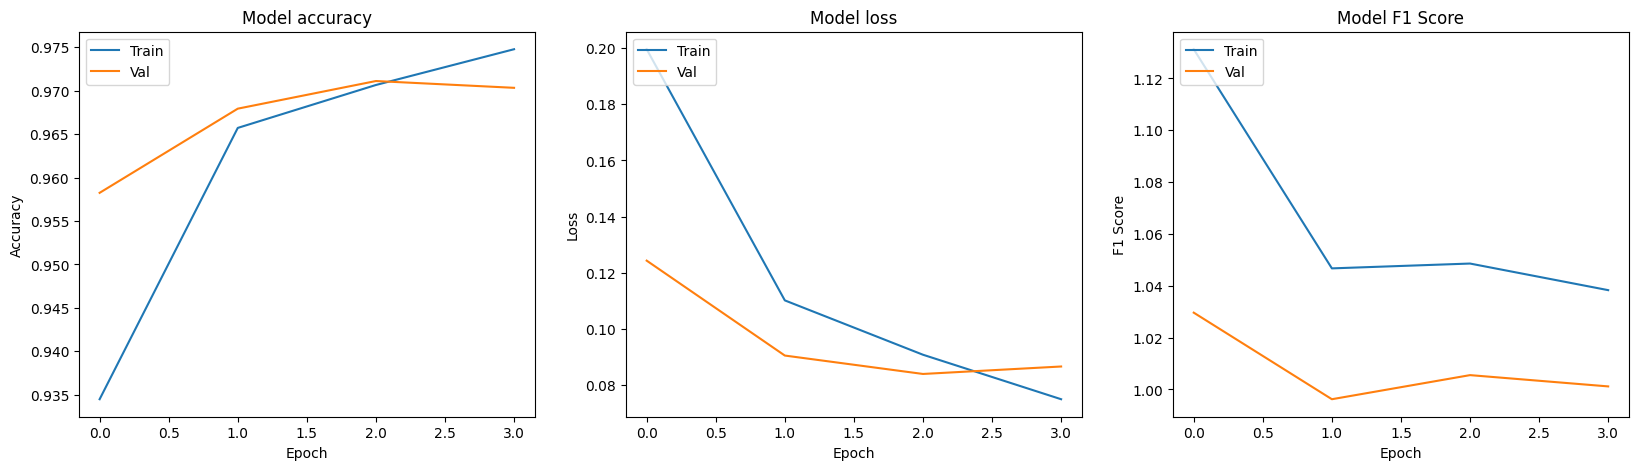

In [22]:
def plot_training_history(history):
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))
    
    # Plot training & validation accuracy values
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Val'], loc='upper left')

    # Plot training & validation loss values
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Val'], loc='upper left')
    
    # Plot training & validation F1 score values
    ax[2].plot(history.history['f1_metric'])
    ax[2].plot(history.history['val_f1_metric'])
    ax[2].set_title('Model F1 Score')
    ax[2].set_ylabel('F1 Score')
    ax[2].set_xlabel('Epoch')
    ax[2].legend(['Train', 'Val'], loc='upper left')

    plt.show()

plot_training_history(history)


##  Generate the Confusion Matrix and Metrics

With the true labels and predictions, we can now generate a confusion matrix and calculate other evaluation metrics like precision, recall, and F1-score.

2995/2995 [==============================] - 277s 91ms/step


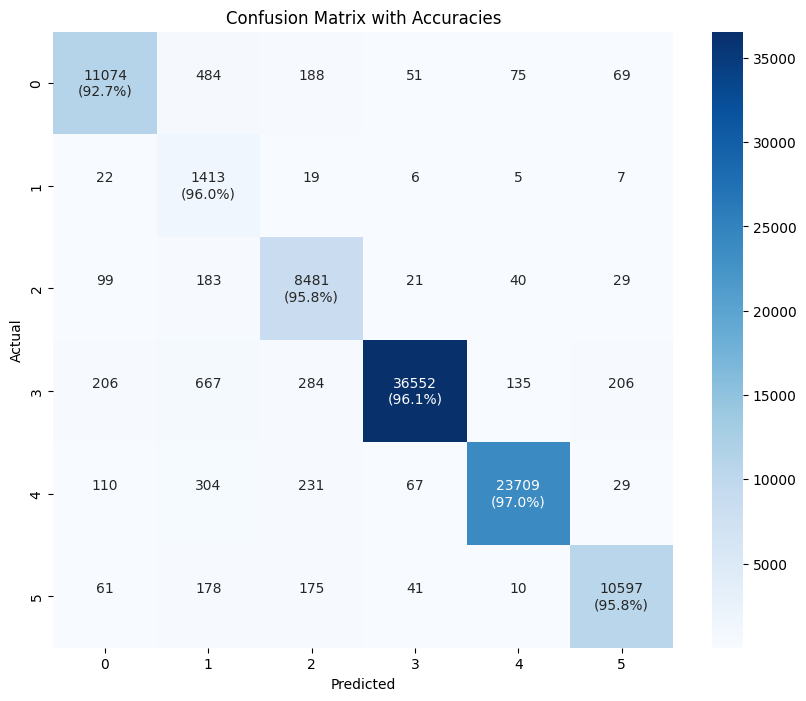

In [23]:
# Assuming X_val and y_val are your test inputs and labels, respectively.
# If you have a separate test set, replace X_val and y_val accordingly.

# Predict classes with the model
predictions = model.predict({"input_ids": X_val, "attention_mask": val_mask})
predicted_labels = np.argmax(predictions.logits, axis=1)

# Since your labels are already encoded with LabelEncoder, there's no need to decode them

# Generate the confusion matrix
cm = confusion_matrix(y_val, predicted_labels)

# Calculate per-class accuracies
accuracies = cm.diagonal() / cm.sum(axis=1)

# Create an annotated confusion matrix with accuracies
cm_with_acc = cm.astype('str')  # Convert counts to string for annotation
for i in range(len(cm)):
    for j in range(len(cm[i])):
        # Append accuracy to the diagonal elements
        if i == j:
            cm_with_acc[i][j] = f"{cm[i][j]}\n({accuracies[i]*100:.1f}%)"
        else:
            cm_with_acc[i][j] += "\n "

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm, annot=cm_with_acc, fmt='', ax=ax, cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix with Accuracies')
plt.show()


## Prepare the Submission DataFrame and Save

In [24]:
# Load the test dataset
test_df = pd.read_csv('test (1).csv', sep='\t')

# Replace the exclamation point at the end of each sentence with a dot
test_df['sentence'] = test_df['sentence'].str.replace(r'!\s*$', '.', regex=True)

# Assuming 'sentence' is your column of interest and tokenizer is already defined
# Prepare the test sentences with RobertaTokenizer
test_input_ids = []
test_attention_masks = []

for sent in test_df['sentence']:
    encoded_dict = tokenizer.encode_plus(
                        sent,                        # Sentence to encode
                        add_special_tokens = True,   # Add '[CLS]' and '[SEP]'
                        max_length = 128,            # Pad & truncate all sentences
                        pad_to_max_length = True,
                        return_attention_mask = True,# Construct attention masks
                        return_tensors = 'tf',       # Return tf tensors
                   )
    
    # Add the encoded sentence to the list
    test_input_ids.append(encoded_dict['input_ids'])
    test_attention_masks.append(encoded_dict['attention_mask'])

# Convert lists into tensors
test_input_ids = tf.concat(test_input_ids, axis=0)
test_attention_masks = tf.concat(test_attention_masks, axis=0)

# Make predictions using the trained model
predictions = model.predict({"input_ids": test_input_ids, "attention_mask": test_attention_masks})
predicted_labels = np.argmax(predictions.logits, axis=1)

# Convert numeric predictions back to original labels using the LabelEncoder
predicted_emotions = label_encoder.inverse_transform(predicted_labels)

# Prepare the submission DataFrame
submission_df = pd.DataFrame({
    'id': test_df['id'],  # Assuming there's an 'id' column in your test set
    'emotion': predicted_emotions
})

# Save the submission file
submission_df.to_csv('Roberta_V3_1p_task12_2.csv', index=False, sep=',')


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


45/45 [==============================] - 4s 92ms/step


In [25]:
import joblib

# Define the base path for saving
base_save_path = "Roberta_V3_1p_task12"

# Specify the paths for the model, tokenizer, and label encoder
model_save_path = f"{base_save_path}/model"
tokenizer_save_path = f"{base_save_path}/tokenizer"
label_encoder_save_path = f"{base_save_path}/label_encoder.joblib"

# Assuming `model` is your TFRobertaForSequenceClassification model,
# `tokenizer` is your RobertaTokenizer, and `label_encoder` is your LabelEncoder instance

# Save the model
model.save_pretrained(model_save_path)

# Save the tokenizer
tokenizer.save_pretrained(tokenizer_save_path)

# Save the label encoder
joblib.dump(label_encoder, label_encoder_save_path)

['Roberta_V3_1p_task12/label_encoder.joblib']

In [26]:
data_sub = 'Roberta_V3_1p_task12_2.csv'

# Load the dataset
data_submission = pd.read_csv(data_sub)

# Define the mapping from integer labels to emotion names
emotion_mapping = {
    0: 'anger',
    1: 'disgust',
    2: 'fear',
    3: 'happiness',
    4: 'sadness',
    5: 'surprise'
}

# Apply the mapping to the 'emotion' column
data_submission['emotion'] = data_submission['emotion'].map(emotion_mapping)
# Save the submission file
data_submission.to_csv('Roberta_V3_1p_task12_2.csv', index=False, sep=',')